In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from edge_pydb import util, EdgeTable
from edge_pydb.conversion import bpt_type, bpt_prob, kewley01, kauffm03, cidfer10
from edge_pydb.plotting import xy2hist
from astropy.table import Table, Column, join
import scipy

In [2]:
mpl.rcParams['axes.linewidth'] = 1.5

In [3]:
fluxtab = EdgeTable('edge_carma.2d_smo7.hdf5', path='flux_elines_sm')

In [4]:
print(len(fluxtab))

231125


In [5]:
fluxtab = fluxtab[~np.isnan(fluxtab['BPT_sm'])]
print(len(fluxtab))

37974


In [6]:
fluxtab

Name,ix,iy,ra_abs,dec_abs,ra_off,dec_off,rad_arc,azi_ang,flux_[OII]3727_sm,flux_[OIII]5007_sm,flux_[OIII]4959_sm,flux_Hbeta_sm,flux_[OI]6300_sm,flux_Halpha_sm,flux_[NII]6583_sm,flux_[NII]6548_sm,flux_[SII]6717_sm,flux_[SII]6731_sm,vel_[OII]3727_sm,vel_[OIII]5007_sm,vel_[OIII]4959_sm,vel_Hbeta_sm,vel_[OI]6300_sm,vel_Halpha_sm,vel_[NII]6583_sm,vel_[NII]6548_sm,vel_[SII]6717_sm,vel_[SII]6731_sm,disp_[OII]3727_sm,disp_[OIII]5007_sm,disp_[OIII]4959_sm,disp_Hbeta_sm,disp_[OI]6300_sm,disp_Halpha_sm,disp_[NII]6583_sm,disp_[NII]6548_sm,disp_[SII]6717_sm,disp_[SII]6731_sm,EW_[OII]3727_sm,EW_[OIII]5007_sm,EW_[OIII]4959_sm,EW_Hbeta_sm,EW_[OI]6300_sm,EW_Halpha_sm,EW_[NII]6583_sm,EW_[NII]6548_sm,EW_[SII]6717_sm,EW_[SII]6731_sm,e_flux_[OII]3727_sm,e_flux_[OIII]5007_sm,e_flux_[OIII]4959_sm,e_flux_Hbeta_sm,e_flux_[OI]6300_sm,e_flux_Halpha_sm,e_flux_[NII]6583_sm,e_flux_[NII]6548_sm,e_flux_[SII]6717_sm,e_flux_[SII]6731_sm,e_vel_[OII]3727_sm,e_vel_[OIII]5007_sm,e_vel_[OIII]4959_sm,e_vel_Hbeta_sm,e_vel_[OI]6300_sm,e_vel_Halpha_sm,e_vel_[NII]6583_sm,e_vel_[NII]6548_sm,e_vel_[SII]6717_sm,e_vel_[SII]6731_sm,e_disp_[OII]3727_sm,e_disp_[OIII]5007_sm,e_disp_[OIII]4959_sm,e_disp_Hbeta_sm,e_disp_[OI]6300_sm,e_disp_Halpha_sm,e_disp_[NII]6583_sm,e_disp_[NII]6548_sm,e_disp_[SII]6717_sm,e_disp_[SII]6731_sm,e_EW_[OII]3727_sm,e_EW_[OIII]5007_sm,e_EW_[OIII]4959_sm,e_EW_Hbeta_sm,e_EW_[OI]6300_sm,e_EW_Halpha_sm,e_EW_[NII]6583_sm,e_EW_[NII]6548_sm,e_EW_[SII]6717_sm,e_EW_[SII]6731_sm,flux_Hbeta_sm3_sm,flux_Halpha_sm3_sm,flux_sigsfr0_sm,e_flux_sigsfr0_sm,flux_sigsfr_corr_sm,e_flux_sigsfr_corr_sm,flux_AHa_corr_sm,e_flux_AHa_corr_sm,flux_AHa_smooth3_sm,flux_sigsfr_adopt_sm,BPT_sm,p_BPT_sm,SF_BPT_sm,ZOH_sm,e_ZOH_sm,ZOH_N2_sm,e_ZOH_N2_sm
,,,deg,deg,deg,deg,arcsec,deg,1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),1e-16 erg / (s cm2),km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,km / s,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,Angstrom,1e-16 erg / (s cm2),1e-16 erg / (s cm2),solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / (Gyr pc2),solMass / (Gyr pc2),mag,mag,mag,solMass / (Gyr pc2),,,,dex,dex,dex,dex
bytes13,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bool,float32,float32,float32,float32
ARP220,28,64,233.749237,23.503666,0.010905,-0.000000,35.717,-17.211,0.52902985,0.057509426,-0.052478943,0.025519662,0.002422131,0.12542504,0.104688816,0.06854123,0.051779617,0.0766798,4906.82,5274.0757,5451.4453,5246.768,5310.6455,5359.8545,5095.76,5629.4624,5398.3813,5372.899,14.713301,11.784027,5.576481,12.041791,12.0048275,9.60197

In [7]:
N2F = fluxtab['flux_[NII]6583_sm']
O3F = fluxtab['flux_[OIII]5007_sm']
HaF = fluxtab['flux_Halpha_sm']
HbF = fluxtab['flux_Hbeta_sm']
ZOH = fluxtab['ZOH_sm']

In [8]:
def bptplot(N2F, O3F, HaF, HbF, cond=None, label=None, ZOH=None, outfile='plot'):

    fig, ax = plt.subplots(1, 1, figsize=(8,8))
    if cond is None:
        cond = np.full_like(N2F, True, dtype=bool)
    print(f'Valid points selected: {np.count_nonzero(cond)} out of {len(cond)}')
    n2ha = np.log10(N2F[cond]) - np.log10(HaF[cond])
    o3hb = np.log10(O3F[cond]) - np.log10(HbF[cond])
    bpt = fluxtab['BPT_sm'][cond]

    if ZOH is None:
        ax.scatter(n2ha[bpt == -1], o3hb[bpt == -1], label=f'SF region ({len(n2ha[bpt==-1])})')
    else:
        moh = ZOH[cond]
        sc = plt.scatter(n2ha[bpt==-1], o3hb[bpt==-1], c=moh[bpt==-1], cmap='jet', label=f'SF region ({len(n2ha[bpt==-1])})')
        cax = fig.add_axes([ax.get_position().x1+0.02, ax.get_position().y0,
                            0.03, ax.get_position().height])
        cb = fig.colorbar(sc, cax=cax)
        cb.set_label('12 + log(O/H)', size=13,labelpad=5)
    ax.scatter(n2ha[bpt == 0],  o3hb[bpt == 0],  label=f'Composite ({len(n2ha[bpt==0])})')
    ax.scatter(n2ha[bpt == 1],  o3hb[bpt == 1],  label=f'LINER ({len(n2ha[bpt==1])})')
    ax.scatter(n2ha[bpt == 2],  o3hb[bpt == 2],  label=f'Seyfert ({len(n2ha[bpt==2])})')

    x_det, y_det, z_det, *hist = xy2hist(n2ha, o3hb, log=False, bins=[40,40])
    hist[0] = (hist[0]-np.min(hist[0]))/(np.max(hist[0])-np.min(hist[0]))
    hist[0] = scipy.ndimage.zoom(hist[0], 5, order=1)
    print('min and max:',hist[0].min(), hist[0].max())
    ax.contour(hist[0].transpose(),[0.1,0.2,0.4,0.8],
               extent=[hist[1].min(),hist[1].max(),
                       hist[2].min(),hist[2].max()],
               colors='k',linewidths=2,zorder=5, alpha=0.5)

    x1 = np.linspace(-2.5, -0.05, 100)
    x2 = np.linspace(-1.2805, 0.35, 100)
    x3 = np.linspace(-0.19935, 1.5,100)
    ax.plot(x3, cidfer10(x3), 'k-')
    ax.plot(x2, kewley01(x2), 'k:')
    ax.plot(x1, kauffm03(x1), 'k--')
    ax.set_xlabel(r'log [NII]/H$\alpha$', fontsize=20, labelpad=6)
    ax.set_ylabel(r'log [OIII]/H$\beta$', fontsize=20, labelpad=6)
    ax.set_xlim([-1.75, 0.75])
    ax.set_ylim([-1.75, 1.25])
    ax.legend(loc=3, fontsize=15, framealpha=0.8)
    ax.tick_params(axis='both', labelsize=14)
    if label is not None:
        ax.text(0.02, 0.95, label, fontsize=18, transform=ax.transAxes)
    k1 = ax.text(0.51, 0.02, 'Kau03', fontsize=16, transform=ax.transAxes)
    k1.set_bbox(dict(facecolor='white', alpha=0.75, linewidth=0))
    k2 = ax.text(0.82, 0.02, 'Kew01', fontsize=16, transform=ax.transAxes)
    k2.set_bbox(dict(facecolor='white', alpha=0.8, linewidth=0))
    ax.text(0.89, 0.86, 'Cid10', fontsize=16, rotation=40, transform=ax.transAxes)
    plt.savefig('bpt_'+outfile+'.pdf', bbox_inches='tight')
    plt.savefig('bpt_'+outfile+'.png', bbox_inches='tight')

Valid points selected: 26126 out of 37974
min and max: 0.0 0.9937580623017118


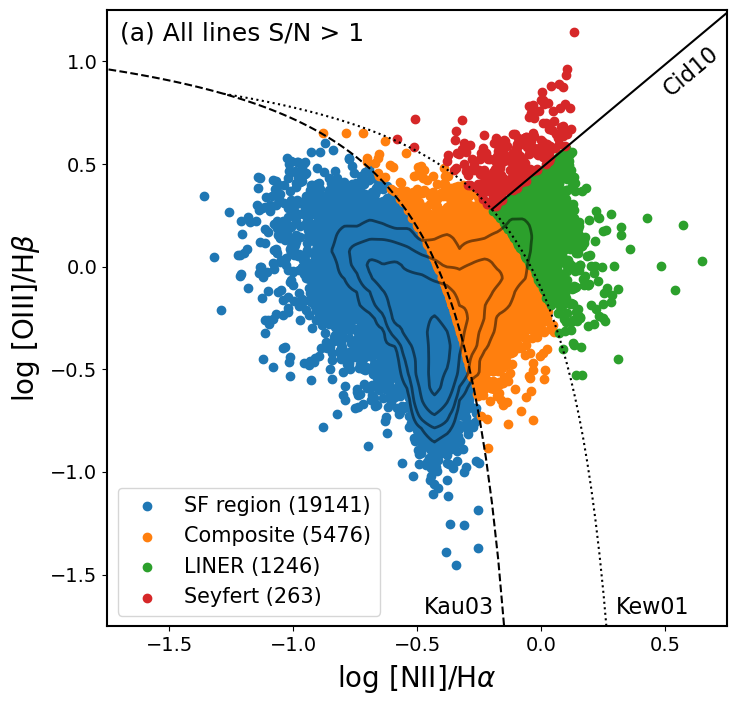

In [9]:
snrcut = 1
N2g = (abs(fluxtab['e_flux_[NII]6583_sm']/fluxtab['flux_[NII]6583_sm']) < 1/snrcut)
O3g = (abs(fluxtab['e_flux_[OIII]5007_sm']/fluxtab['flux_[OIII]5007_sm']) < 1/snrcut)
Hag = (abs(fluxtab['e_flux_Halpha_sm']/fluxtab['flux_Halpha_sm']) < 1/snrcut)
Hbg = (abs(fluxtab['e_flux_Hbeta_sm']/fluxtab['flux_Hbeta_sm']) < 1/snrcut)
cond = N2g & O3g & Hag & Hbg
bptplot(N2F, O3F, HaF, HbF, cond=cond, label='(a) All lines S/N > 1', outfile='allpts')

Valid points selected: 15320 out of 37974
min and max: 0.0 0.9792698446069305


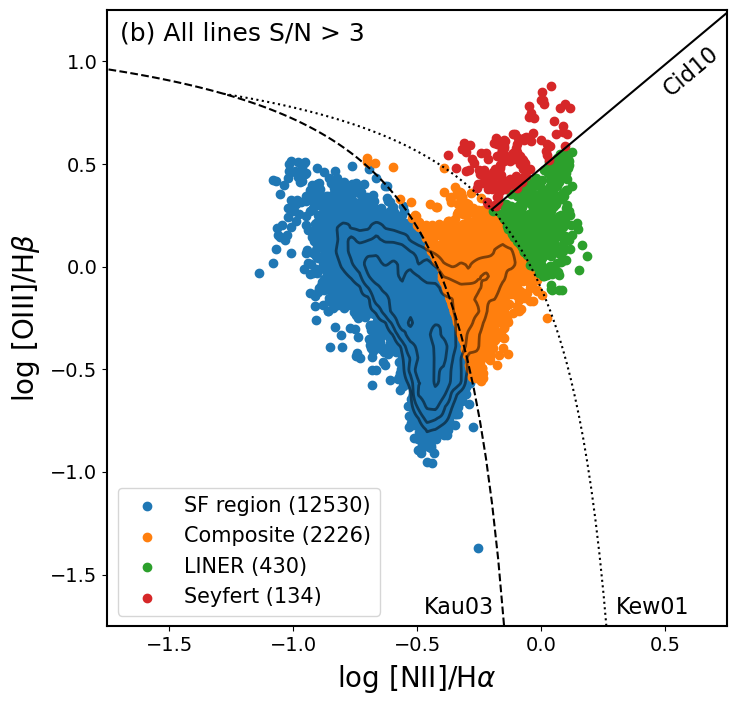

In [10]:
snrcut = 3
N2g = (abs(fluxtab['e_flux_[NII]6583_sm']/fluxtab['flux_[NII]6583_sm']) < 1/snrcut)
O3g = (abs(fluxtab['e_flux_[OIII]5007_sm']/fluxtab['flux_[OIII]5007_sm']) < 1/snrcut)
Hag = (abs(fluxtab['e_flux_Halpha_sm']/fluxtab['flux_Halpha_sm']) < 1/snrcut)
Hbg = (abs(fluxtab['e_flux_Hbeta_sm']/fluxtab['flux_Hbeta_sm']) < 1/snrcut)
cond = N2g & O3g & Hag & Hbg
bptplot(N2F, O3F, HaF, HbF, cond=cond, label='(b) All lines S/N > 3', outfile='sncut3')

# Color code SF points by metallicity

Valid points selected: 15320 out of 37974
min and max: 0.0 0.9792698446069305


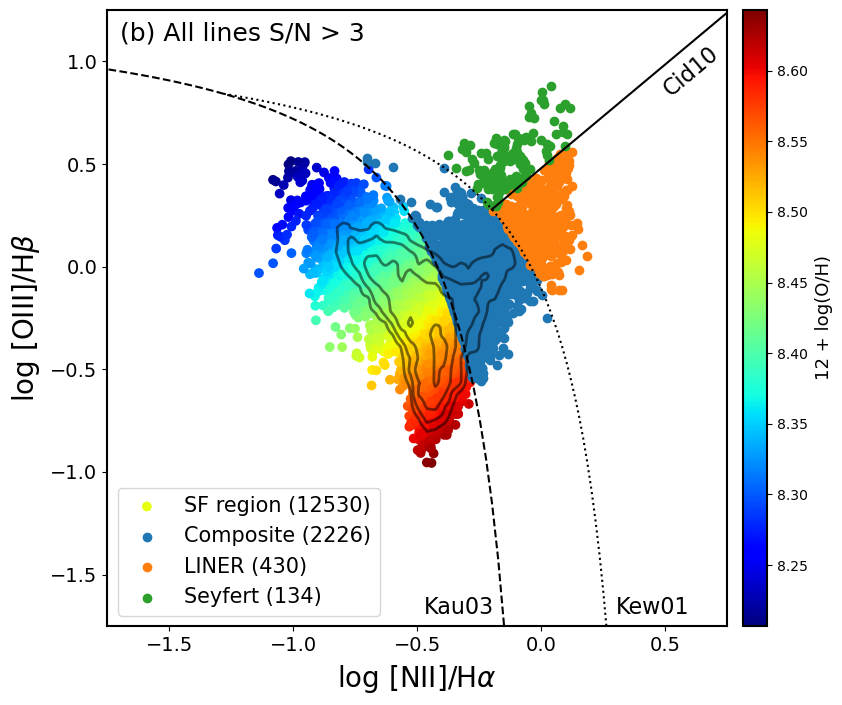

In [11]:
snrcut = 3
N2g = (abs(fluxtab['e_flux_[NII]6583_sm']/fluxtab['flux_[NII]6583_sm']) < 1/snrcut)
O3g = (abs(fluxtab['e_flux_[OIII]5007_sm']/fluxtab['flux_[OIII]5007_sm']) < 1/snrcut)
Hag = (abs(fluxtab['e_flux_Halpha_sm']/fluxtab['flux_Halpha_sm']) < 1/snrcut)
Hbg = (abs(fluxtab['e_flux_Hbeta_sm']/fluxtab['flux_Hbeta_sm']) < 1/snrcut)
cond = N2g & O3g & Hag & Hbg
bptplot(N2F, O3F, HaF, HbF, cond=cond, ZOH=ZOH, label='(b) All lines S/N > 3', outfile='sncut3_zoh')

Valid points selected: 19270 out of 37974
min and max: 0.0 0.9877592943095754


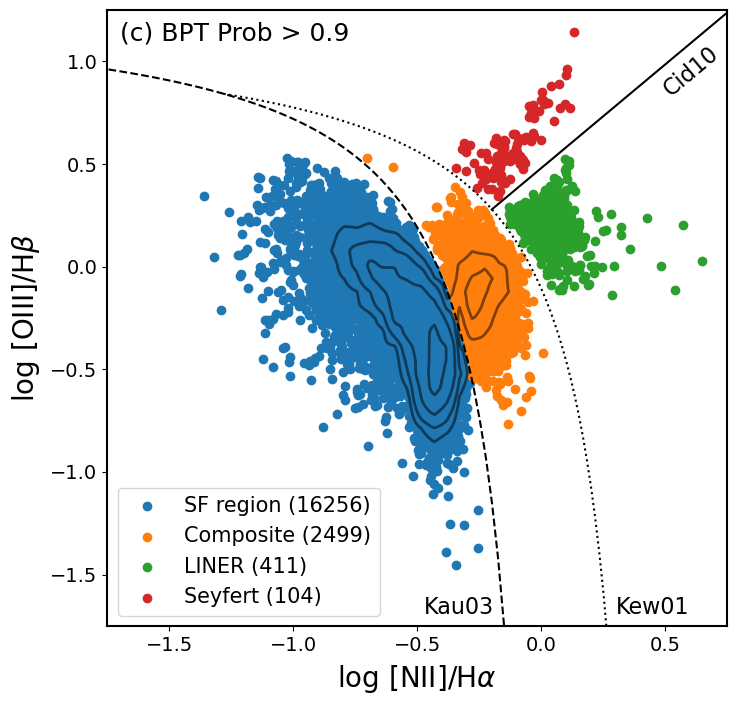

In [12]:
snrcut = 1
N2g = (abs(fluxtab['e_flux_[NII]6583_sm']/fluxtab['flux_[NII]6583_sm']) < 1/snrcut)
O3g = (abs(fluxtab['e_flux_[OIII]5007_sm']/fluxtab['flux_[OIII]5007_sm']) < 1/snrcut)
Hag = (abs(fluxtab['e_flux_Halpha_sm']/fluxtab['flux_Halpha_sm']) < 1/snrcut)
Hbg = (abs(fluxtab['e_flux_Hbeta_sm']/fluxtab['flux_Hbeta_sm']) < 1/snrcut)
cond = N2g & O3g & Hag & Hbg & (fluxtab['p_BPT_sm'] > 0.9)
bptplot(N2F, O3F, HaF, HbF, cond=cond, label='(c) BPT Prob > 0.9', outfile='prob_0p9')